In [ ]:
from pip import main
main(["install","xgboost"])

In [54]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [25]:
df_train = pd.read_csv("train.csv")
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Analyzing the variable to predict

In [26]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

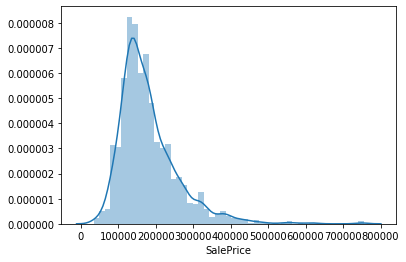

In [27]:
sns.distplot(df_train['SalePrice'])

#### Relationship with numerical variables

In [28]:
df_train.columns.to_series().groupby(df_train.dtypes).groups

{dtype('int64'): Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
       dtype='object'),
 dtype('float64'): Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object'),
 dtype('O'): Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 

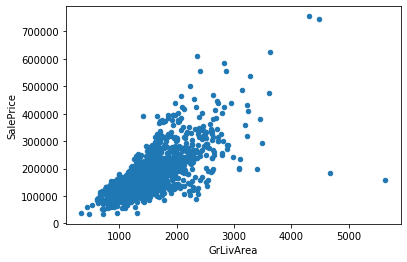

In [29]:
df_train[["SalePrice","GrLivArea"]].plot.scatter(x='GrLivArea',y='SalePrice') # can see a linear relation

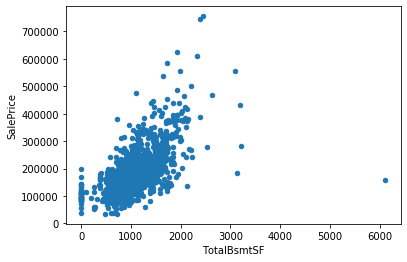

In [30]:
df_train[["SalePrice","TotalBsmtSF"]].plot.scatter(x='TotalBsmtSF',y='SalePrice') # linear but tending to exponential

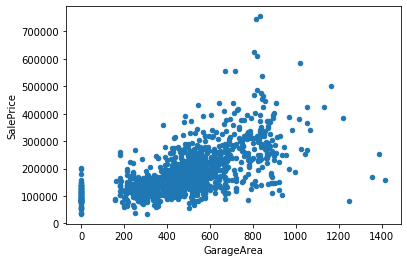

In [31]:
df_train[["SalePrice","GarageArea"]].plot.scatter(x='GarageArea',y='SalePrice') # again a linear relation

#### Relationship with Categorical variables

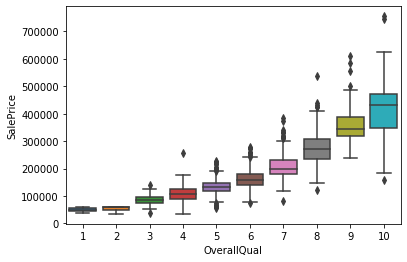

In [32]:
sns.boxplot(x='OverallQual', y='SalePrice', data=df_train[["SalePrice","OverallQual"]]) # A linear relation with increasing quality 

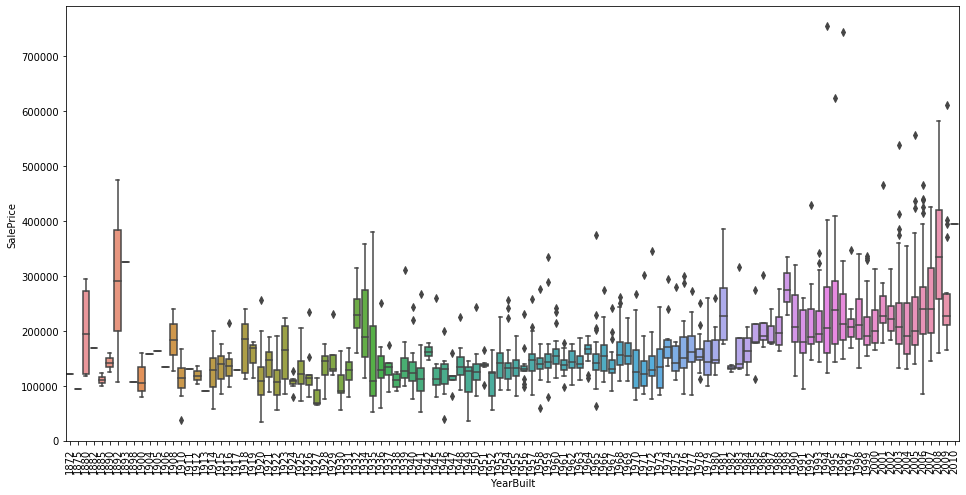

In [33]:
plt.subplots(figsize=(16, 8))
plt.xticks(rotation=90)
sns.boxplot(x='YearBuilt', y='SalePrice', data=df_train[["SalePrice","YearBuilt"]])

#### Objective Analysis

##### Correlation Matrix

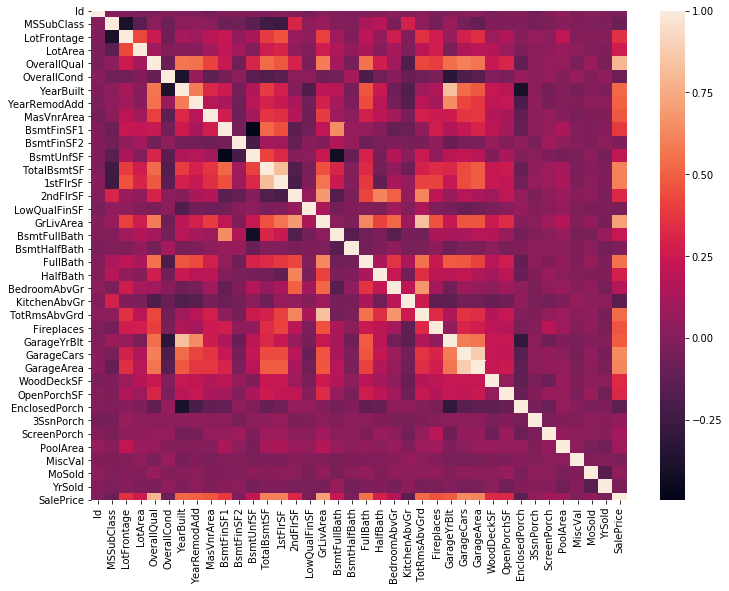

In [34]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat) # there are instances of multicollinearity that can be seen from the matrix

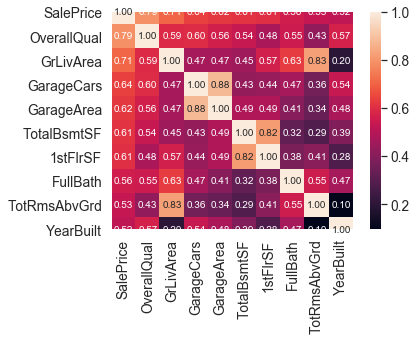

In [37]:
# Zoomed correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index # get top 10 correlated variables with Sale Price
cm = np.corrcoef(df_train[cols].values.T) # transpose 
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [38]:
# OverallQual, GrLivArea and TotalBsmtSF are strongly correlated with SalePrice
# GarageCars and GarageArea are also correlated but one of them is needed as depend on each other
# TotalBsmtSF and 1stFloor, TotRmsAbvGrd and GrLivArea seem to be twin brothers
# FullBath is correlated but practically not sure 

##### Pairplots

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


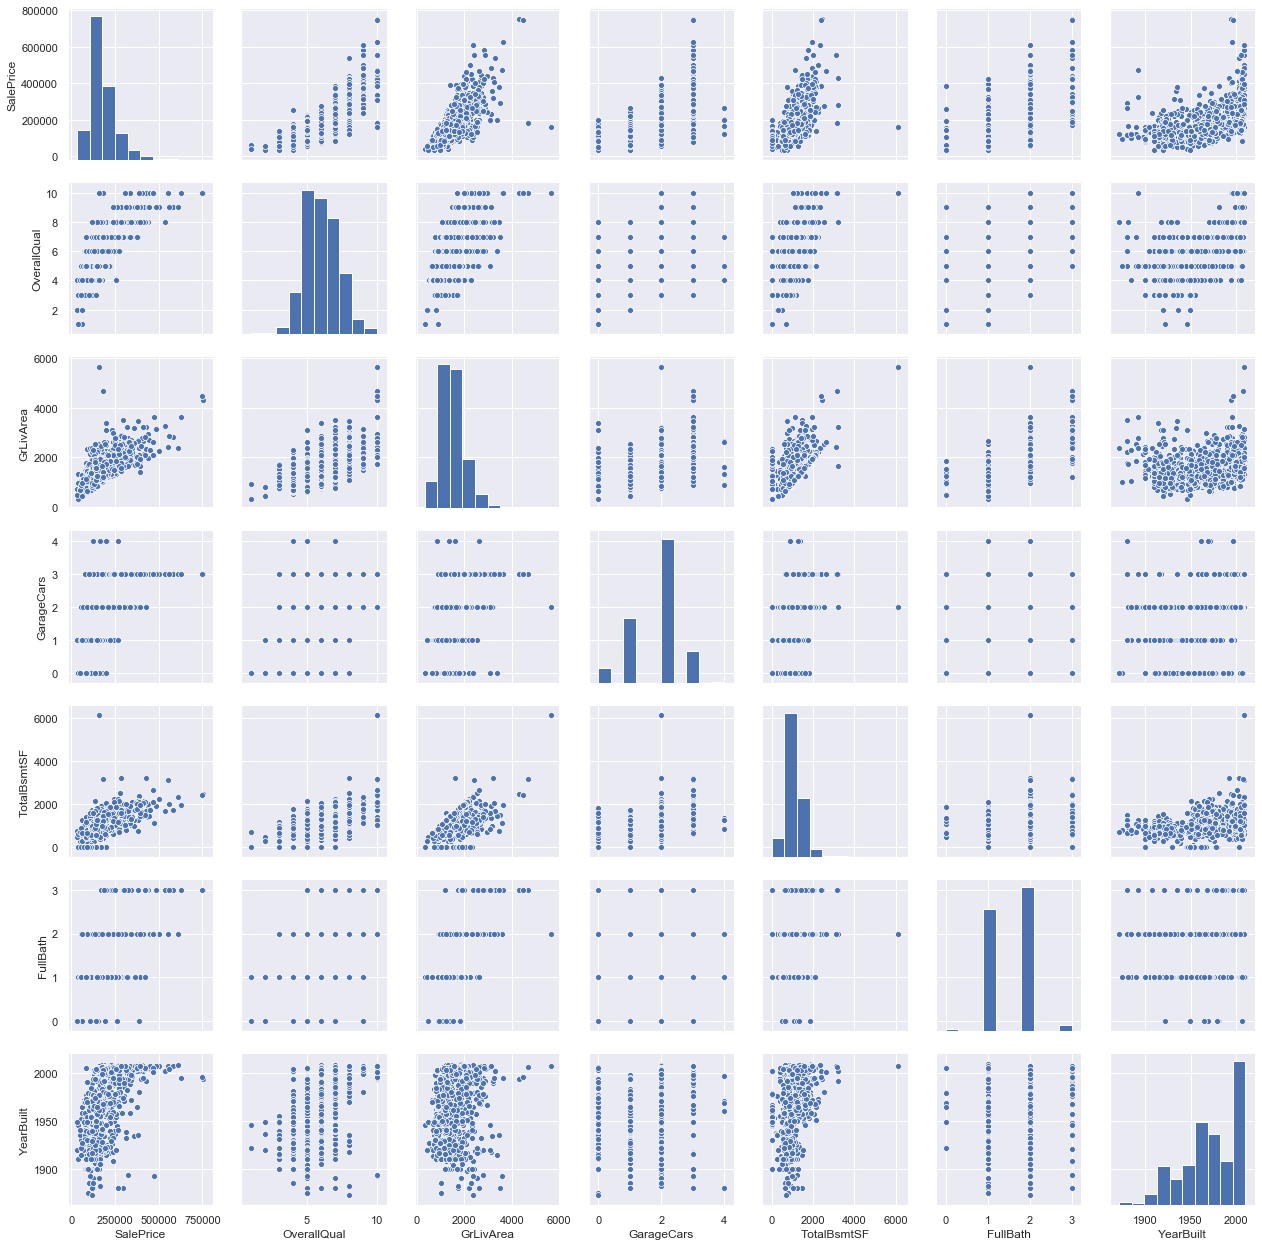

In [39]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show()

#### Missing Data

In [40]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


We will not consider the variables which have more than 15% of the data as missing cause it would be difficult to impute them 

We will delete all the variables with missing data, except the variable 'Electrical'. In 'Electrical' we'll just delete the observation with missing data

In [42]:
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #just checking 

0

#### Outliars

##### Univariate analysis

In [45]:
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis])
# data standardization converts data values to have mean of 0 and a standard deviation of 1.
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


High range values are far from 0 and the 7.something values are really out of range

##### Bivariate analysis

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


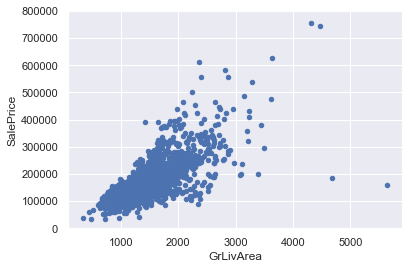

In [46]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

The 2 values with large living area and low saleprice dont follow the trend and are outliars

In [47]:
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


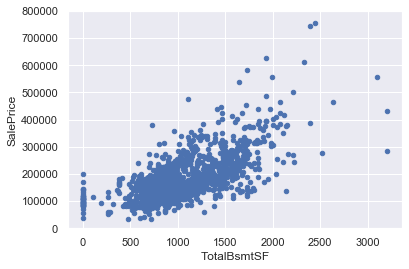

In [48]:
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Through this we are not tempted right away to delete any value considered as outliar

#### Normality

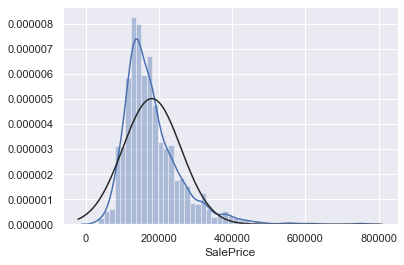

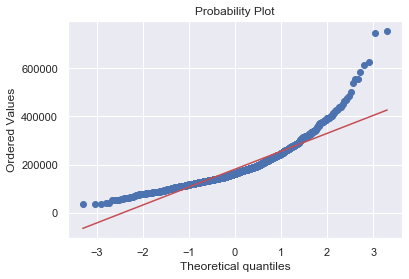

In [55]:
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

SalePrice doesn't follows normal distribution, it has positive skewdness and also is not following the straight line of probability plot. To deal with this issue we can apply a simple log transformation. 

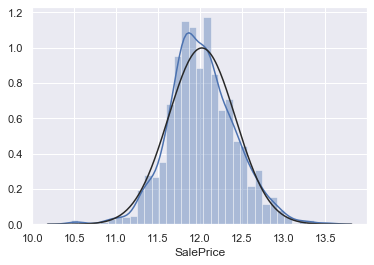

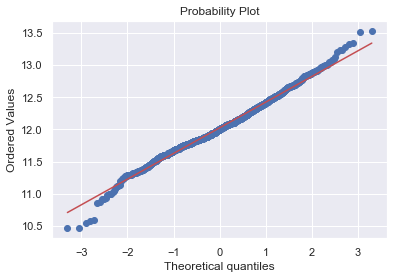

In [56]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])

sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

Moving on to GrLivingArea

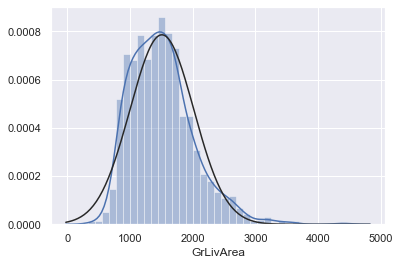

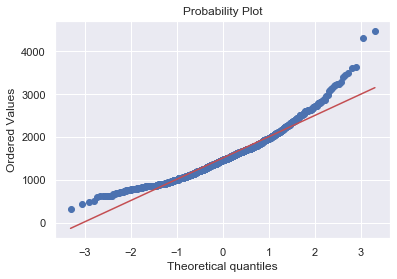

In [57]:
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

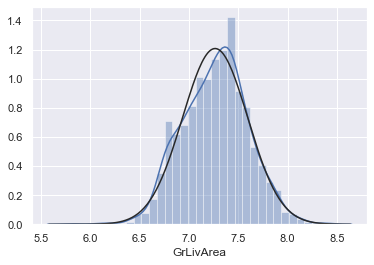

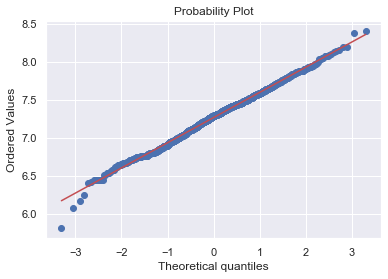

In [58]:
# same solution
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

TotalBsmtSF

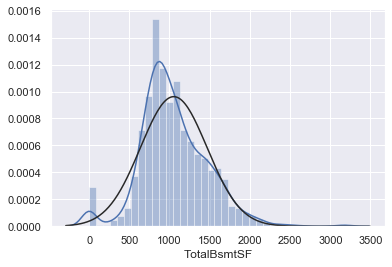

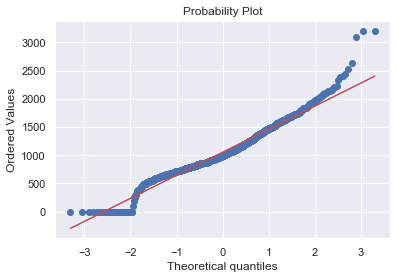

In [59]:
sns.distplot(df_train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot=plt)

Here we have a different problem as large number of buildings are not having basements so we have many 0 values. So we will do a log transformation of only the non-zero values.

/usr/local/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


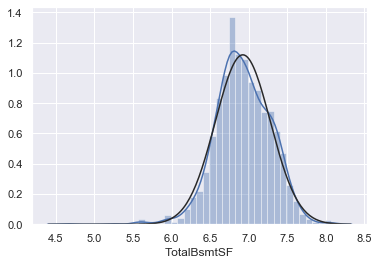

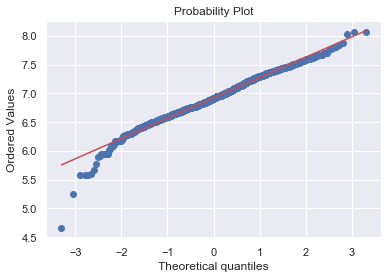

In [60]:
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0 
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1

# transform
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

# plot
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

#### Homoescedasticity 

We usually check this usually graphical plotting of 2 variables. If we see unequal dispersion in the scatter plot in form of cones this means issue exists.

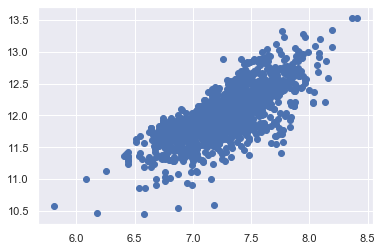

In [61]:
plt.scatter(df_train['GrLivArea'], df_train['SalePrice'])

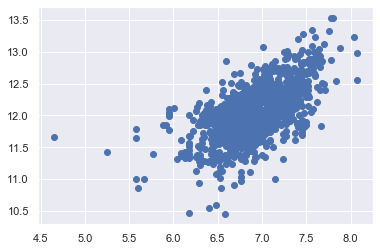

In [62]:
plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], df_train[df_train['TotalBsmtSF']>0]['SalePrice'])

In both the plots we can see that dealing with normality has solved the issue of homoskedasticity as well

#### Dummy variables

We need to convert our categorical variables into dummy variables using one hot encoding

In [63]:
df_train = pd.get_dummies(df_train)

#### Final dataframe

In [64]:
df_train.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,8450,7,5,2003,2003,706,0,150,...,0,0,0,1,0,0,0,0,1,0
1,2,20,9600,6,8,1976,1976,978,0,284,...,0,0,0,1,0,0,0,0,1,0
2,3,60,11250,7,5,2001,2002,486,0,434,...,0,0,0,1,0,0,0,0,1,0
3,4,70,9550,7,5,1915,1970,216,0,540,...,0,0,0,1,1,0,0,0,0,0
4,5,60,14260,8,5,2000,2000,655,0,490,...,0,0,0,1,0,0,0,0,1,0


#### Split into test and train

In [70]:
X = df_train.drop('SalePrice', axis=1)
y = df_train['SalePrice']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### Specify the model

In [83]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

#### Error Metrics

In [84]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

#### Prediction

In [86]:
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_test)
print(rmsle(y_test, xgb_train_pred))

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.12254624191853197


In [ ]:
Code for the project
Presentation slides deck (and an optional blog post if you want to really stand out)
Consolidated report (Google Doc, 10-12 pages) based on summary reports from all your previous project submissions, including:
Proposal with problem statement
Data collection and wrangling summary
Exploratory data analysis summary (visualization and inferential statistics)
Results and In-depth analysis using machine learning
